# Model

In [1]:
! nvidia-smi

/bin/sh: nvidia-smi: command not found


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#export
from xview2comp.nb_01b import *

In [4]:
from fastai.vision import models

# Model

### Unet

Use the Unet that is already available in fastai v1 to begin with.

In [52]:
c = 2
sz = 32 #256

In [53]:
encoder = nn.Sequential(*list(models.resnet34().children())[:-2])

In [54]:
model = models.DynamicUnet(encoder, c, (sz, sz))

In [55]:
model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

### Data

Get `DataBunch`, the data object for modeling.  The following lines are from '01_loda_data.ipynb'.

In [56]:
SOURCE = Path('data/')

In [57]:
bs = 4

In [58]:
fnames = get_files(SOURCE/'train'/'images', extensions=['.png',])
print(len(fnames))
fnames = pre_img_fpaths(fnames)[:1000]

xtfms = [ResizeFixed(sz, resample=PIL.Image.BILINEAR), to_byte_tensor, to_float_tensor, Normalize(1/255)]
il = ImageList(fnames, path=Path('data/train/images/'), tfms=xtfms)

sd = SplitData.split_by_random(il, val_pct=.1)

ytfms = [ResizeFixed(sz, resample=PIL.Image.NEAREST), to_byte_tensor, to_float_tensor]
ll = label_by_func(sd, img2bmask_fpath, listtype=ImageList, tfms=ytfms)
data = ll.to_databunch(bs, num_workers=4)

5598


In [59]:
x, y = next(iter(data.train_dl))

In [60]:
x.shape, y.shape

(torch.Size([4, 3, 32, 32]), torch.Size([4, 1, 32, 32]))

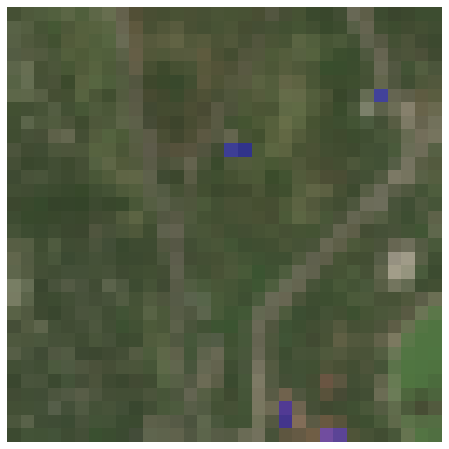

In [61]:
show_sample(x[1], mas=y[1], figsize=(8, 8))

### Forward pass through untrained model

Let's pass a mini-batch through the untrained model to make sure that there is no Exception.

In [62]:
pred = model(x)

In [63]:
pred.argmax(1)[1][None,...].dtype

torch.int64

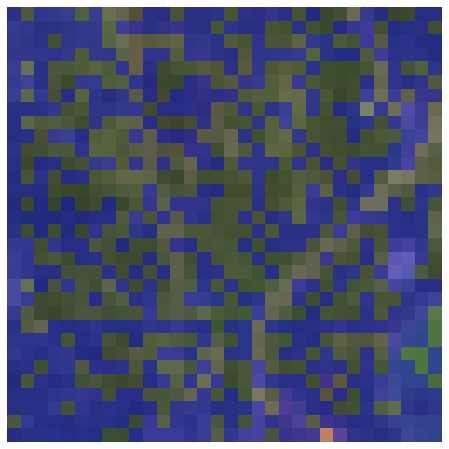

In [65]:
show_sample(x[1], mas=pred.argmax(dim=1)[1][None,...].float(), figsize=(8, 8))

### Loss function

Flatten out the tensor such that dimension 0 lines up all the pixels in the image/mask, then feed to `nn.CrossEntropyLoss`.

In [66]:
pred.permute(0, 2, 3, 1).reshape(-1, 2).shape

torch.Size([4096, 2])

In [67]:
y.permute(0, 2, 3, 1).reshape(-1).shape

torch.Size([4096])

In [68]:
class FlattenedCE():
    def __init__(self): self.loss = nn.CrossEntropyLoss()
    def __call__(self, inp, targ):
        inp = inp.permute(0, 2, 3, 1).reshape(-1, 2)
        targ = targ.permute(0, 2, 3, 1).reshape(-1).long()
        return self.loss(inp, targ)

In [69]:
loss = FlattenedCE()
loss(pred, y)

tensor(0.9271, grad_fn=<NllLossBackward>)

### Metrics

In [70]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask].float() == targ[mask]).float().mean()

In [71]:
foreground_acc(pred, y, bkg_idx=0, axis=1)

tensor(0.3273)

### Learner

`Learner` and `Callback`s make up what's used for the training and validation of the Unet model on the `DataBunch`.  The various definitions for these are slightly scattered among fastai (part2 2019) notebooks, the final versions are gathered here.

In [76]:
cbfs = [Recorder, ProgressCallback, partial(AvgStatsCallback, foreground_acc)] #, CudaCallback]

learn = Learner(model, data, loss_func=FlattenedCE(), cb_funcs=cbfs, lr=1e-1)

In [73]:
learn.fit(1, cbs=[LR_Find(), Recorder(), ])

epoch,train_loss,train_foreground_acc,valid_loss,valid_foreground_acc,time


In [74]:
learn.cbs

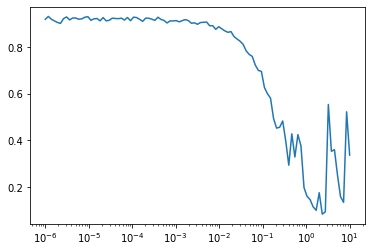

In [75]:
learn.recorder.plot()

In [29]:
learn.opt.hypers[0]['lr'] = .1

In [30]:
learn.fit(1)

epoch,train_loss,train_foreground_acc,valid_loss,valid_foreground_acc,time
0,0.222541,nan,0.208870,0.018300,04:35


In [31]:
learn.opt.hypers[0]

{'lr': 0.1, 'wd': 0.0}

In [32]:
learn.fit(9)

epoch,train_loss,train_foreground_acc,valid_loss,valid_foreground_acc,time
0,0.188173,0.112205,0.178438,0.062451,04:35
1,0.168850,0.166664,0.172033,0.335935,04:37
2,0.162324,0.225382,0.148741,0.113409,04:37
3,0.156802,0.272898,0.139248,0.159991,04:37
4,0.148045,0.319428,0.139113,0.259130,04:38
5,0.145016,0.358990,0.752176,0.929397,04:37
6,0.141337,0.358797,0.121392,0.320464,04:38
7,0.137356,0.397893,0.258919,0.556791,04:37
8,0.137154,0.415948,0.213944,0.503392,04:38


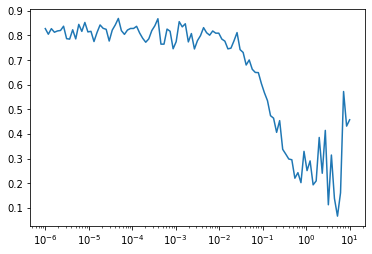

In [34]:
learn.recorder.plot()

In [48]:
SOURCE

[PosixPath('data/train'), PosixPath('data/train.tar.gz')]

In [49]:
torch.save(learn.model.state_dict(), SOURCE/'nepoch_9__lr_0pt1__sz_516')

In [16]:
learn.model.load_state_dict(torch.load(SOURCE/'nepoch_9__lr_0pt1__sz_516'));

In [35]:
del x, y

In [25]:
valid_dl_iter = iter(data.valid_dl)

In [36]:
x, y = next(valid_dl_iter)

In [41]:
pred = model.cpu()(x.cpu())

In [42]:
pred.argmax(dim=1)[idx][None,...].unique()

tensor([0, 1])

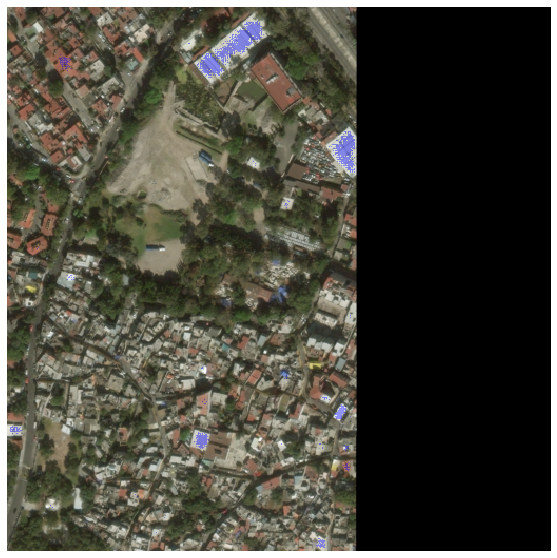

In [43]:
idx = 0
show_sample(x[idx], mas=pred.argmax(dim=1)[idx][None,...], figsize=(10, 10))

# -fin

In [44]:
! python notebook2script.py 02_model.ipynb

Converted 02_model-GCP.ipynb to xview2compgcp/nb_02.py
